In [1]:
import os
import sys
import glob
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sys.path.append('/home/mattolm/Bio_scripts/')

from IPython.display import display, HTML

import scipy.spatial
import sklearn.manifold
import matplotlib.patches as mpatches
import StatsTools

In [2]:
sheetloc = '/data8/Human/FungiPaper/Datasheets/'
fig_loc = '/data8/Human/FungiPaper/figures/'

Pdb = pd.read_csv('/home/mattolm/ReadLists/ProjectInformation/ROOM_project_info.csv')
s2rb = Pdb.set_index('public_code')['read_bases'].to_dict()

### Load Coverage / breadth information

In [6]:
Gdb = pd.read_csv(sheetloc + 'MappingListGamma_strainProfilerv2_v2.3.csv')

## Add some identifying information
Gdb['loc'] = [x[10] for x in Gdb['sample']]
Gdb['room_loc'] = [x[11] for x in Gdb['sample']]
Gdb['infant'] = [x[:6] for x in Gdb['sample']]

## Subset to room
Gdb = Gdb[~Gdb['loc'].isin(['G', 'E'])]

## Filter 
BREADTH = 0.5
Gdb = Gdb.sort_values('mm').drop_duplicates(subset=['genome', 'sample'], keep='last')
Gdb = Gdb[Gdb['breadth'] >= BREADTH]
#Gdb = Gdb[Gdb['name'] != 'Purpureocillium lilacinum']

## Add percent project
Gdb['pp'] = [((c*l)/s2rb[s]) * 100 for c, l, s in zip(Gdb['coverage'],\
                Gdb['length'], Gdb['sample'])]

In [7]:
Bdb = Gdb[Gdb['name'] != 'Purpureocillium lilacinum']

### Set up naming

In [8]:
n2n = {'C_parapsilosis_CDC317_current_chromosomes': 'Candida parapsilosis',
       'Nectria haematococca mpVI 77-13-4':'Nectria haematococca', 
       'Malassezia globosa CBS 7966':'Malassezia globosa',
       'Purpureocillium lilacinum':'Purpureocillium lilacinum', 
       'S2_005_001R2_Rhabditida':'Rhabditida S2_005_001R2',
       'S2_005_001R2_Verruconis_gallopava':'Verruconis sp. S2_005_001R2',
       'S2_005_002R2_Diptera':'Diptera S2_005_002R2',
       'S2_009_000R2_Exophiala_mesophila':'Exophiala sp. S2_009_000R2',
       'S2_018_000R1_Malassezia_globosa':'Malassezia sp. S2_018_000R1'}
Bdb['name2'] = Bdb['name'].map(n2n)

/home/mattolm/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
Bdb['name2'].value_counts()

Malassezia sp. S2_018_000R1    10
Malassezia globosa              6
Candida parapsilosis            4
Verruconis sp. S2_005_001R2     3
Nectria haematococca            3
Exophiala sp. S2_009_000R2      3
Rhabditida S2_005_001R2         3
Diptera S2_005_002R2            1
Name: name2, dtype: int64

## Compute braycurtis distance between all samples

In [10]:
table = defaultdict(list)

genomes = list(Bdb['genome'].unique())
for samp in Bdb['sample'].unique():
    g2p_1 = Bdb[Bdb['sample'] == samp].set_index('genome')['pp'].to_dict()
    for samp2 in Bdb['sample'].unique():
        g2p_2 = Bdb[Bdb['sample'] == samp2].set_index('genome')['pp'].to_dict()
        
        g1 = [g2p_1[x] if x in g2p_1 else 0 for x in genomes]
        g2 = [g2p_2[x] if x in g2p_2 else 0 for x in genomes]
        dist = scipy.spatial.distance.braycurtis(g1, g2)
        
        table['sample1'].append(samp)
        table['sample2'].append(samp2)
        table['distance'].append(dist)
Ddb = pd.DataFrame(table)

## Set up colors and markers

In [11]:
# Get colors set up (room)
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
c2r = {}
for room, color in zip(Gdb['infant'].unique(),
    ['#e6194b', '#3cb44b', "#ffe119", "#0082c8", "#f58231", "#911eb4"]):
    c2r[room] = color
    
s2m = {'1':'o', '2':'^', '3':'s'}

## Make MDS plot

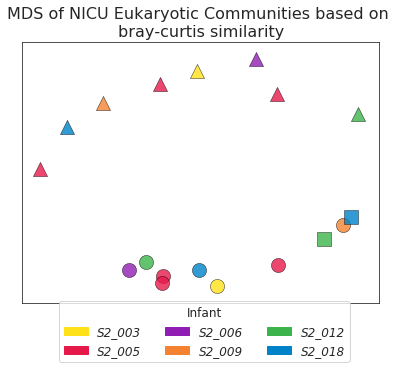

In [29]:
# Get set up
linkage_db = Ddb.pivot("sample1","sample2","distance")
names = list(linkage_db.columns)
mds = sklearn.manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(linkage_db)
stress = results.stress_

# Pull coordinates
coords = results.embedding_
sns.set_style('white')
sns.set_context(font_scale=1.5)

# Plot one at a time
for name, x, y in zip(names, coords[:, 0], coords[:, 1]):
    # set color
    colors = [c2r[name[:6]]]
    # set marker
    m = s2m[name[11]]
    
    plt.scatter(
        x, y, marker = m, linestyle = 'None',\
        color=colors, s=200,  edgecolors='black', linewidths=0.5, alpha=0.8)

# Horrible annotation
if False:
    for label, x, y in zip(names, coords[:, 0], coords[:, 1]):
        plt.annotate(
            label,
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

# Add color legend
legendC = c2r
patches = [mpatches.Patch(color = color, label = label)
            for label, color in zip(sorted(list(legendC.keys())),\
            [c2r[x] for x in sorted(legendC.keys())])]
lgd = plt.legend(patches, sorted(list(legendC.keys())), loc='lower center', \
            prop = {'size': 12, 'style': 'italic'}, title='Infant', ncol=3, bbox_to_anchor=(.51, -0.25))

# Adjust figure properties
axes = plt.gca()
fig = plt.gcf()
fig.set_size_inches(6.4, 4.8)
plt.title('MDS of NICU Eukaryotic Communities based on \nbray-curtis similarity', size=16)
plt.xticks([])
plt.yticks([])

#plt.savefig(fig_loc + 'NICU_MDS_v3' + ".pdf",format="pdf",transparent=True, bbox_inches='tight')
plt.show()

### Calculate stress

In [30]:
normstress = np.sqrt(stress /
                             ((linkage_db.values.ravel() ** 2).sum() / 2))
normstress

0.23282790893827157

### circle = 1 (highly touched), triangle = 2 (sink), square = 3 (wipes)

# Look at bar charts of those genomes in all rooms

https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/

/home/mattolm/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


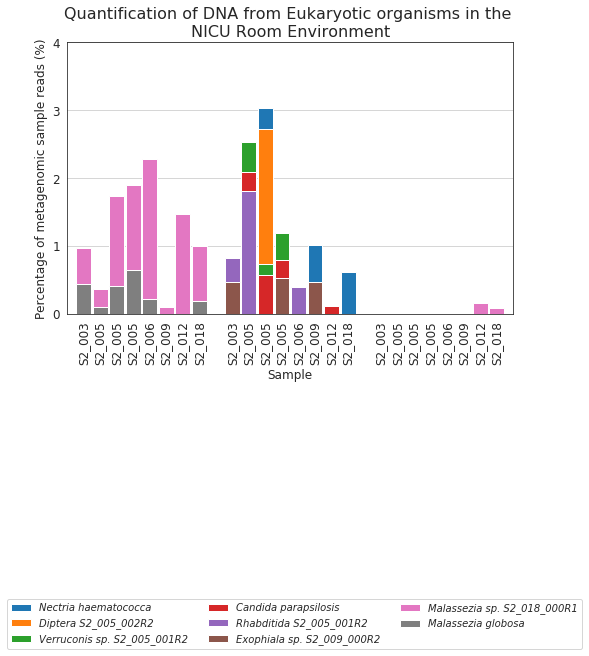

In [13]:
def simple_stacks_v2_custom(data, x, y, hue, palette = False, size = (5, 3), \
                    xlim = False, ylim = False, xtitle='', ytitle='',\
                    width = 0.75, title='', save=False, x2x=None):
    """
    plot stacked bar chart
    
    * v2 = just cleaned up a little with more comments and other minor fixes
    
    palette = hue -> color
    """

    # legend
    plt.legend(loc='best', prop = {'size': 10})

    # order to plot each item based on most abundant first
    items = list(data[hue].unique()) # all hues (genomes)
#     items = [(sum([i for i in data[data[hue] == s][y].values\
#                    if type(i) is float]), s) for s in items] # (sum of values, hue)
#     items = [i[1] for i in sorted(items, reverse = True)] # hues ordered by sum

    # values
    X_labels = list(data[x].unique()) # All x labels
    X = list(range(0, len(X_labels))) # range of x labels

    # count data for plotting
    running = [0 for i in X]
    Iabundance = [] # [hue, [sum(hue) for every x + previous hues], [sum(hue) for every x ]]
    for s in items:
        hdb = data[data[hue] == s] # dataframe with only this hue (s)
        abundance = [] # list of the abundance of values for this hue
        for xi in X_labels:
            a = np.nan_to_num(hdb[hdb[x] == xi][y].values) # all values of this hue + x
            if len(a) == 0:
                abundance.append(0)
            else:
                a = [i for i in a if type(i) is not str] 
                abundance.append(np.nansum(a)) # append all values
                
        running = [i + j for i, j in zip(running, abundance)] # this hue + all previous hues
        Iabundance.append([s, running, abundance])
    
    # plot abundance
    for s, running, abundance in Iabundance[::-1]:
        # s = hue, running = [sum(x) + previous for x in hue]
        if palette == False:
            plt.bar(X, running, \
                             label = s,\
                            width = width, alpha = 1)
        else:
            plt.bar(X, running, \
                             label = s, color = palette[s],\
                            width = width, alpha = 1)
    if x2x != None:
        plt.xticks([xi for xi in X], [x2x[x] if x[-1] != 'X' else '' for x in X_labels], rotation='vertical')
    else:
        plt.xticks([xi for xi in X], [x if x[-1] != 'X' else '' for x in X_labels], rotation='vertical')
    #plt.xticks(X, X_labels, rotation='vertical')

    # legend
    plt.legend(loc='lower center', bbox_to_anchor=(.51, -1.25), \
            prop = {'size': 10, 'style': 'italic'}, ncol=3)
    
#     plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)

    # ylim
    if ylim != False:
        plt.ylim(0,ylim)
        
    # xlim
    plt.xlim(-1, len(X_labels))

    # title
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    # save
    if save != False:
        plt.savefig(str(save) + ".pdf",format="pdf",transparent=True, bbox_inches='tight')

Fdb = Bdb.copy()

# Add blanks
table = defaultdict(list)
for b in ['bl1', 'bl2'] + list(set(Pdb['public_code']) - set(Fdb['sample'])):
    table['sample'].append(b)
    table['name2'].append(Fdb['name2'].tolist()[0])
    table['pp'].append(0)
Fdb = Fdb.append(pd.DataFrame(table))
    
# Re-order
#print('",\\\n"'.join(list(Gdb['sample'].unique())))
order = [\
"S2_003_000R1",\
"S2_005_001R1",\
"S2_005_002R1",\
"S2_005_003R1",\
"S2_006_000R1",\
"S2_009_000R1",\
"S2_012_000R1",\
"S2_018_000R1",\
"bl1",\
"S2_003_000R2",\
"S2_005_001R2",\
"S2_005_002R2",\
"S2_005_003R2",\
"S2_006_000R2",\
"S2_009_000R2",\
"S2_012_000R2",\
"S2_018_000R2",\
"bl2",\
"S2_003_000R3",\
"S2_005_001R3",\
"S2_005_002R3",\
"S2_005_003R3",\
"S2_006_000R3",\
"S2_009_000R3",\
"S2_012_000R3",\
"S2_018_000R3"]
Fdb['sample'] = pd.Categorical(Fdb['sample'], order)
Fdb.sort_values(['sample', 'name2'], inplace=True)
#assert len(Fdb['sample'].unique()) == 26, len(Fdb['sample'].unique())

# set up xlabel translation
#s2s = {'R1':'swabs', 'R2':'sinks', 'R3':'wipes'}
x2x = {x:x[:6] for x in Fdb['sample'].unique()}
x2x['bl1'] = ''
x2x['bl2'] = ''

# Do normal plot
sns.set_style('white')
matplotlib.rcParams.update({'font.size': 12})
simple_stacks_v2_custom(data=Fdb, x='sample', y='pp', hue='name2', width=0.9, x2x=x2x)

# Adjust
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)
plt.ylim(0,4)
plt.yticks([0,1,2,3,4])
plt.gca().yaxis.grid(True)
plt.ylabel('Percentage of metagenomic sample reads (%)')
plt.xlabel("Sample")
plt.title('Quantification of DNA from Eukaryotic organisms in the \nNICU Room Environment', size=16)

#plt.savefig(fig_loc + 'raw_NICU_Quant_v3' + ".pdf",format="pdf",transparent=True, bbox_inches='tight')
plt.show()